### **Mestrado Profisional PROFICAM - ITV**

## **Introdução a Visão Computacional**

### Aula 03.2 - Segmentação, Features (detecção de faces)

Documentação extra do OpenCV pode ser visualizada em: https://docs.opencv.org/master/d6/d00/tutorial_py_root.html

In [2]:
# import para melhorar a compatibilidade entre python2 e python3 
from __future__ import print_function

# Imports necessários

from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import imutils

import cv2
# from google.colab.patches import cv2_imshow
# cv2_imshow pode ser usado tambem para mostrar imagens ao invez do matplotlib
# so funciona no google colab!
%matplotlib inline

In [3]:
print("OpenCV version:", cv2.__version__)

OpenCV version: 4.1.2


Inicialmente precisamos clonar o repositorio com as imagens que vamos usar para os experimentos

In [17]:
# Baixar os arquivos necessários para a aula
!rm -rf intro_cv_proficam
!git clone https://github.com/h3ct0r/intro_cv_proficam
!cp -r intro_cv_proficam/img .

Cloning into 'intro_cv_proficam'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 69 (delta 9), reused 65 (delta 8), pack-reused 0
Unpacking objects: 100% (69/69), done.


## Detecção apenas da face

OpenCV tem varias ferramentas prontas para deteccção de elementos numa cena. Uma ferramenta útil é a deteccção de faces: usando classificadores em cascata, é possivel fazer deteccção de faces de forma rápida (algoritmo viola-jones)

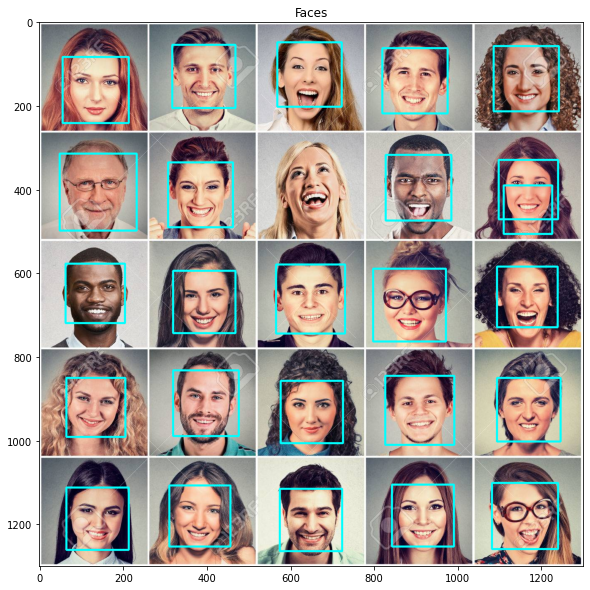

In [20]:
img = cv2.imread('img/faces.jpg')
#img = cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # equivalente a img = imagem[:,:,::-1] # inverte de BGR para RGB
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # equivalente a img = imagem[:,:,::-1] # inverte de BGR para RGB

#Criação do detector de faces
dface = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = dface.detectMultiScale(gray, scaleFactor = 1.05, minNeighbors = 7, minSize = (30,30), flags = cv2.CASCADE_SCALE_IMAGE)

#Desenha retangulos azuis nas faces na imagem original (colorida)
for(x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 3)
    
plt.figure(figsize=(14, 10)) # LARGura e ALTura da imagem total em polegadas
plt.subplot2grid((1,1),(0,0)) #(linhas, colunas) do grid (l,c) do elemento
plt.title('Faces')
plt.imshow(img)

## Detecção da face e olhos

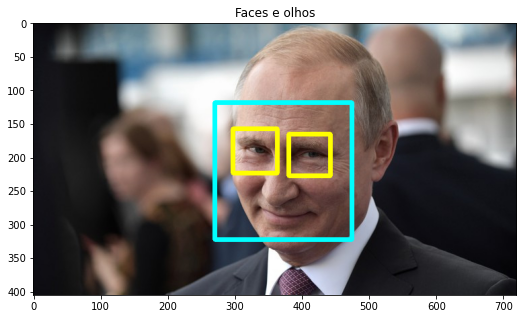

In [22]:
img = cv2.imread('img/putin3.jpg')
#img = cv2.GaussianBlur(img, (7, 7), cv2.BORDER_DEFAULT)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # equivalente a img = imagem[:,:,::-1] # inverte de BGR para RGB
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # equivalente a img = imagem[:,:,::-1] # inverte de BGR para RGB

#Criação do detector de faces
dface = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
deye = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

faces = dface.detectMultiScale(gray, scaleFactor = 1.05, minNeighbors = 7, minSize = (30,30), flags = cv2.CASCADE_SCALE_IMAGE)
olhos = deye.detectMultiScale(gray, scaleFactor = 1.05, minNeighbors = 7, minSize = (30, 30), flags = cv2.CASCADE_SCALE_IMAGE)

#Desenha retangulos azuis nas faces na imagem original (colorida)
img_output = img.copy()
for(x, y, w, h) in faces:
    cv2.rectangle(img_output, (x, y), (x + w, y + h), (0, 255, 255), 5)

#Desenha retangulos amarelos nos olhos imagem original (colorida)
for(x, y, w, h) in olhos:
    cv2.rectangle(img_output, (x, y), (x + w, y + h), (255, 255, 0), 5)

plt.figure(figsize=(14, 5)) # LARGura e ALTura da imagem total em polegadas    
plt.subplot2grid((1,1),(0,0)) #(linhas, colunas) do grid (l,c) do elemento
plt.title('Faces e olhos')
plt.imshow(img_output)

### Adicionando novos olhos 

In [23]:
def overlay_transparent(background_img, img_to_overlay_t, x, y, overlay_size=None):
    """
    @brief      Overlays a transparant PNG onto another image using CV2
    
    @param      background_img    The background image
    @param      img_to_overlay_t  The transparent image to overlay (has alpha channel)
    @param      x                 x location to place the top-left corner of our overlay
    @param      y                 y location to place the top-left corner of our overlay
    @param      overlay_size      The size to scale our overlay to (tuple), no scaling if None
    
    @return     Background image with overlay on top
    """
    
    bg_img = background_img.copy()
    
    if overlay_size is not None:
        img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)

    # Extract the alpha mask of the RGBA image, convert to RGB 
    b,g,r,a = cv2.split(img_to_overlay_t)
    overlay_color = cv2.merge((b,g,r))
    
    # Apply some simple filtering to remove edge noise
    mask = cv2.medianBlur(a,5)

    h, w, _ = overlay_color.shape
    roi = bg_img[y:y+h, x:x+w]

    # Black-out the area behind the logo in our original ROI
    img1_bg = cv2.bitwise_and(roi.copy(),roi.copy(),mask = cv2.bitwise_not(mask))
    
    # Mask out the logo from the logo image.
    img2_fg = cv2.bitwise_and(overlay_color,overlay_color,mask = mask)

    # Update the original image with our new ROI
    bg_img[y:y+h, x:x+w] = cv2.add(img1_bg, img2_fg)

    return bg_img

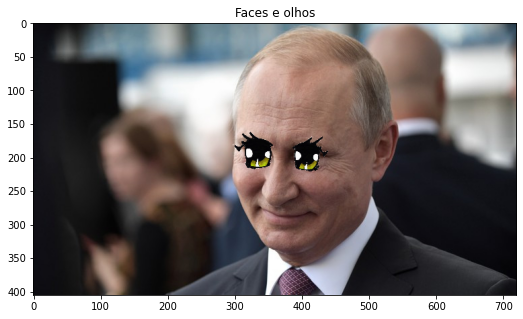

In [24]:
eye_left = cv2.imread('img/eye_left3.png', cv2.IMREAD_UNCHANGED)
eye_right = cv2.imread('img/eye_right3.png', cv2.IMREAD_UNCHANGED)

if len(olhos) != 2:
    raise ValueError("error: not two eyes were detected!")
    
img_overlay = img.copy()

# img left
x, y, w, h = olhos[0]
img_overlay = overlay_transparent(img, eye_left, x, y, overlay_size=(w, h))

# img right
x, y, w, h = olhos[1]
img_overlay = overlay_transparent(img_overlay, eye_right, x, y, overlay_size=(w, h))
    
plt.figure(figsize=(14, 5)) # LARGura e ALTura da imagem total em polegadas    
plt.subplot2grid((1,1),(0,0)) #(linhas, colunas) do grid (l,c) do elemento
plt.title('Faces e olhos')
plt.imshow(img_overlay)